In [1]:
# import necessary libraries

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import seaborn as sns
import matplotlib.pyplot as plt                         # Import plt for visualization
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from wordcloud import WordCloud,STOPWORDS               # Import wordcloud

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer
from sklearn.model_selection import train_test_split         # Import train_test_split
from sklearn.ensemble import RandomForestClassifier          # Import Classifier
from sklearn.model_selection import cross_val_score          # Import cross validation
from sklearn.metrics import classification_report         # Import Classification report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1) Data Summary:

In [2]:
tweets=pd.read_csv('Tweets.csv')  # Importing the data
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
print("Shape of data:", tweets.shape)

Shape of data: (14640, 15)


### Data description:
- A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [4]:
tweets['airline_sentiment'].unique()         #check the labels

array(['neutral', 'positive', 'negative'], dtype=object)

In [5]:
tweets['airline_sentiment'].value_counts()       # check the count of each labels

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

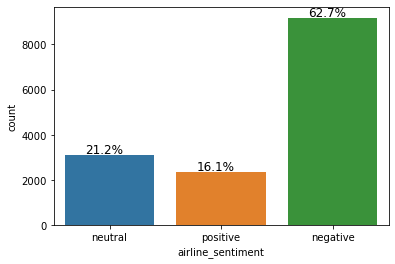

In [6]:
#plot the distribution of the class label
def bar_plot(data, feature):
    plot = sns.countplot(x =feature, data = data)
    total = len(data)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y),ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points")
    plt.show()
    
bar_plot(tweets,'airline_sentiment')

- The dataset is imbalanced, majority of records are of negative airline sentiment.

**Word Cloud for Negative Reasons:**

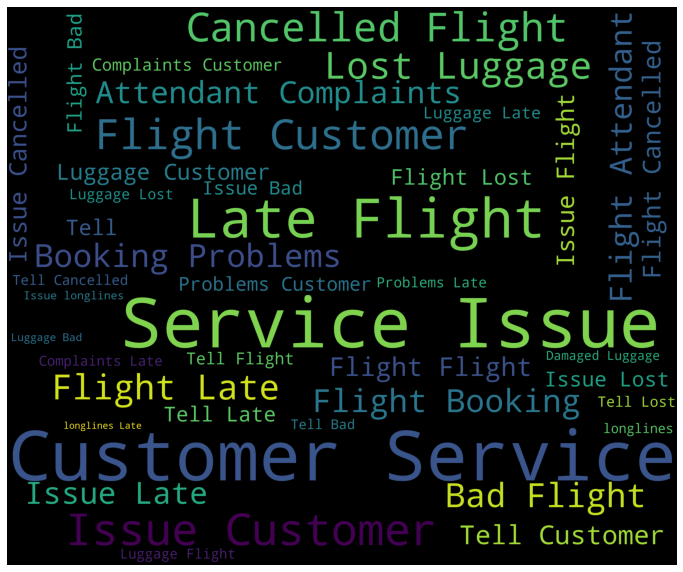

In [7]:
#creating word cloud for negative reasons
negative_reasons=tweets[tweets['negativereason'].notnull()]
words = ' '.join(negative_reasons['negativereason'])
cleaned_word = " ".join([word for word in words.split()])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- Some common negative reasons are late flight, customer service, attendant complaints, flight cancelled, etc.

**Word Cloud for Negative Airline Sentiment:**

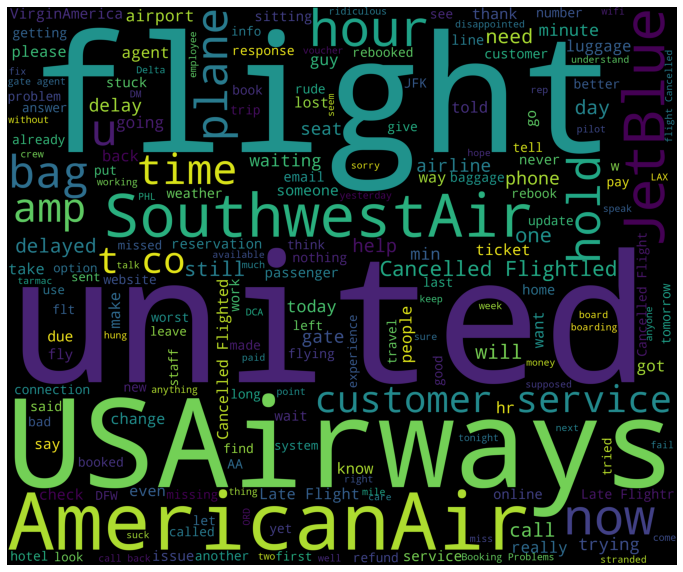

In [8]:
#creating word cloud for negative airline sentiment
negative_reviews=tweets[tweets['airline_sentiment']=='negative']
words = ' '.join(negative_reviews['text'])
cleaned_word = " ".join([word for word in words.split()])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- delayed, waiting, ridiculous, cancelled flight, booking prolems were some of the important recurring words observed in the negative sentiment.

**Word Cloud for Neutral Airline Sentiment:**

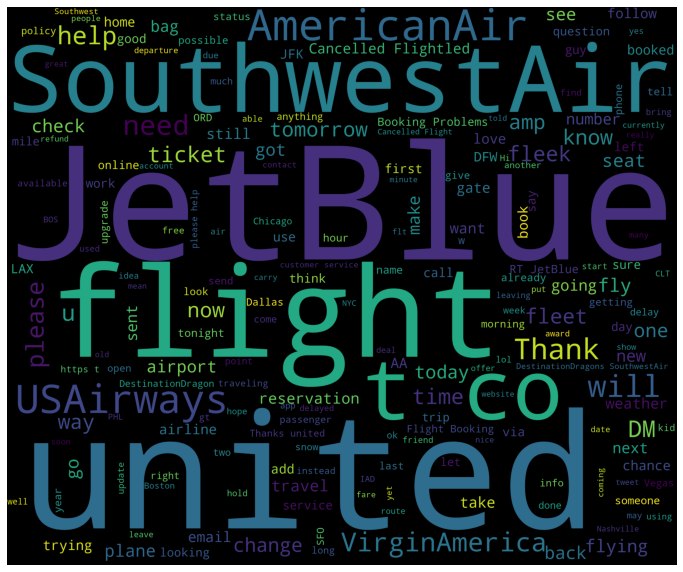

In [9]:
#creating word cloud for positive airline sentiment
neutral_reviews=tweets[tweets['airline_sentiment']=='neutral']
words = ' '.join(neutral_reviews['text'])
cleaned_word = " ".join([word for word in words.split()])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- tomorrow, need, change, reservation, ticket, know, fleet, will, please were some of the important words observed in the neutral sentiment.

**Word Cloud for Positive Airline Sentiment:**

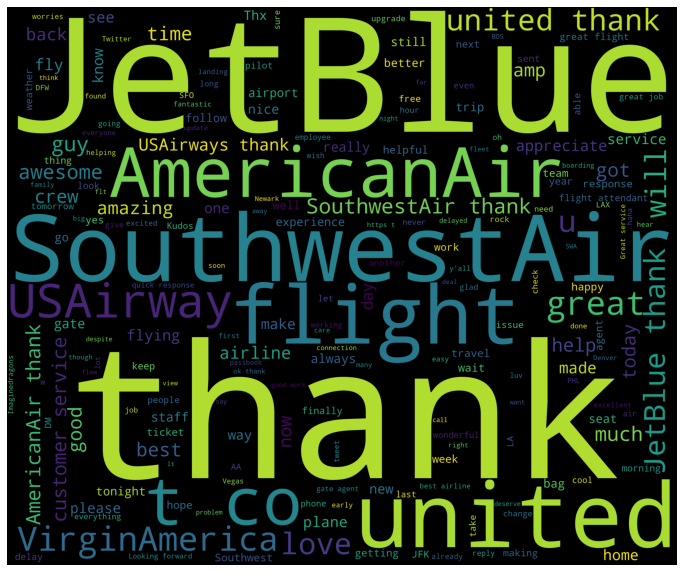

In [10]:
#creating word cloud for positive airline sentiment
positive_reviews=tweets[tweets['airline_sentiment']=='positive']
words = ' '.join(positive_reviews['text'])
cleaned_word = " ".join([word for word in words.split()])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- great, amazing, best, good, awesome, help were some of the important words observed in the positive sentiment.

## 2) Understanding of Data Columns

Drop all other columns except “text” and “airline_sentiment”:

In [11]:
tweets = tweets[['text','airline_sentiment']]
print("Shape of data:", tweets.shape)   # Check the shape of the data
tweets.head()          #  Print the first 5 rows of data

Shape of data: (14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [12]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14640 non-null  object
 1   airline_sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


## 3) Data Pre-processing

    a) Html tag removal:

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

tweets['text'] = tweets['text'].apply(lambda x: strip_html(x))

tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


    b) Remove the numbers:

In [14]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

tweets['text'] = tweets['text'].apply(lambda x: remove_numbers(x))
tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


    c) De-contraction of words:

In [15]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

tweets['text'] = tweets['text'].apply(lambda x: replace_contractions(x))

tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you have added commercials...,positive
2,@VirginAmerica I did not today... Must mean I ...,neutral
3,@VirginAmerica it is really aggressive to blas...,negative
4,@VirginAmerica and it is a really big bad thin...,negative


    d) Tokenization:

In [16]:
tweets['text'] = tweets.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
tweets.head()

,text,airline_sentiment
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral
1,"[@, VirginAmerica, plus, you, have, added, com...",positive
2,"[@, VirginAmerica, I, did, not, today, ..., Mu...",neutral
3,"[@, VirginAmerica, it, is, really, aggressive,...",negative
4,"[@, VirginAmerica, and, it, is, a, really, big...",negative


    e) Removal of Special Characters and Punctuations:

In [17]:
def remove_special_characters_and_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: remove_special_characters_and_punctuation(x))
tweets.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, you, have, added, commer...",positive
2,"[VirginAmerica, I, did, not, today, Must, mean...",neutral
3,"[VirginAmerica, it, is, really, aggressive, to...",negative
4,"[VirginAmerica, and, it, is, a, really, big, b...",negative


    f) Remove non-ascii character:

In [18]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: remove_non_ascii(x))
tweets.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, you, have, added, commer...",positive
2,"[VirginAmerica, I, did, not, today, Must, mean...",neutral
3,"[VirginAmerica, it, is, really, aggressive, to...",negative
4,"[VirginAmerica, and, it, is, a, really, big, b...",negative


    g) Removal of stopwords:

In [19]:
stopwords = stopwords.words('english')
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))                 

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: remove_stopwords(x))
tweets.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, added, commercials, expe...",positive
2,"[VirginAmerica, I, not, today, Must, mean, I, ...",neutral
3,"[VirginAmerica, really, aggressive, blast, obn...",negative
4,"[VirginAmerica, really, big, bad, thing]",negative


    h) Conversion to lowercase:

In [20]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: to_lowercase(x))
tweets.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",neutral
1,"[virginamerica, plus, added, commercials, expe...",positive
2,"[virginamerica, i, not, today, must, mean, i, ...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


    i) Lemmatization:

In [21]:
lemmatizer = WordNetLemmatizer()

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

tweets['text'] = tweets['text'].apply(lambda x: lemmatize_list(x))
tweets.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, say]",neutral
1,"[virginamerica, plus, add, commercials, experi...",positive
2,"[virginamerica, i, not, today, must, mean, i, ...",neutral
3,"[virginamerica, really, aggressive, blast, obn...",negative
4,"[virginamerica, really, big, bad, thing]",negative


Now, join the words in the list to convert back to text string in the data frame (so that each row
          contains the data in text format):

In [22]:
tweets['text'] = tweets['text'].apply(lambda words: ' '.join(words))

# Print the first 5 rows of data after pre-processing
tweets.head()

,text,airline_sentiment
0,virginamerica what dhepburn say,neutral
1,virginamerica plus add commercials experience ...,positive
2,virginamerica i not today must mean i need tak...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


## 4) Vectorization
### 4.1) CountVectorizer 

In [23]:
# Vectorization (Convert text data to numbers).

Count_vec = CountVectorizer(max_features=5000)                # Keep only 5000 features as number of features will increase the processing time.
data_features1 = Count_vec.fit_transform(tweets['text'])

data_features1 = data_features1.toarray()                       # Convert the data features to array.

data_features1.shape                                           #Shape of the feature vector

(14640, 5000)

### 4.2) Term Frequency(TF) - Inverse Document Frequency(IDF)

In [24]:
# Using TfidfVectorizer to convert text data to numbers.

tfidf_vect = TfidfVectorizer(max_features=5000)          # Keep only 5000 features as number of features will increase the processing time.
data_features2 = tfidf_vect.fit_transform(tweets['text'])

data_features2 = data_features2.toarray()                  # Convert the data features to array.

data_features2.shape                                      #Shape of the feature vector

(14640, 5000)

## 5) Modelling and Evaluation

First let's create a function to make confusion matrix with clearer labelings.

In [25]:
## Function to create confusion matrix
def make_confusion_matrix(y_actual, y_predicted):
    """
    <This fucntion print and plot Confusion matirx to get an idea of 
    how the distribution of the prediction is, among all labels>
    y_actual: ground truth
    y_predicted: predicted values
    """

    conf_mat = confusion_matrix(y_actual, y_predicted)

    print(conf_mat)

    df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative' , 'neutral', 'positive']],
                      columns = [i for i in ['negative' , 'neutral', 'positive']])
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten() / np.sum(conf_mat)]
    sentiments = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    sentiments = np.asarray(sentiments).reshape(3, 3)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=sentiments, fmt="")
    plt.ylabel("True sentiment")
    plt.xlabel("Predicted sentiment")

### 5.1) Using CountVectorizer

In [26]:
labels = tweets['airline_sentiment']

# Split data into training and testing set.
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_features1, labels, test_size=0.25, 
                                                        stratify=labels, random_state=42)

In [27]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(1,25).tolist()
base_ln

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [28]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train1, y_train1, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

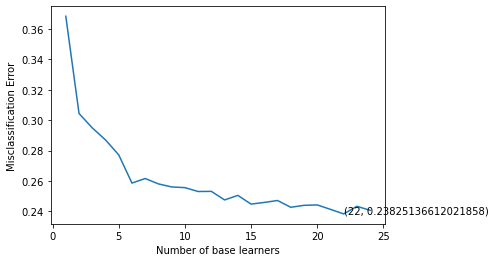

In [29]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [30]:
# Training the best model and calculating accuracy on test data .
clf1 = RandomForestClassifier(n_estimators = optimal_learners)
clf1.fit(X_train1, y_train1)
clf1.score(X_test1, y_test1)

count_vectorizer_predicted = clf1.predict(X_test1)  # #saving the prediction on test data 
print(classification_report(y_test1 ,count_vectorizer_predicted , 
                            target_names = ['negative' , 'neutral', 'positive']))
print("Accuracy of the model is : ",accuracy_score(y_test1,count_vectorizer_predicted))
print("micro avg f1_score of the model is : ", f1_score(y_test1, count_vectorizer_predicted,average='micro'))

              precision    recall  f1-score   support

    negative       0.82      0.91      0.86      2294
     neutral       0.62      0.50      0.55       775
    positive       0.70      0.58      0.64       591

    accuracy                           0.77      3660
   macro avg       0.71      0.66      0.68      3660
weighted avg       0.76      0.77      0.76      3660

Accuracy of the model is :  0.7693989071038252
micro avg f1_score of the model is :  0.7693989071038253


[[2086  136   72]
 [ 317  386   72]
 [ 148   99  344]]


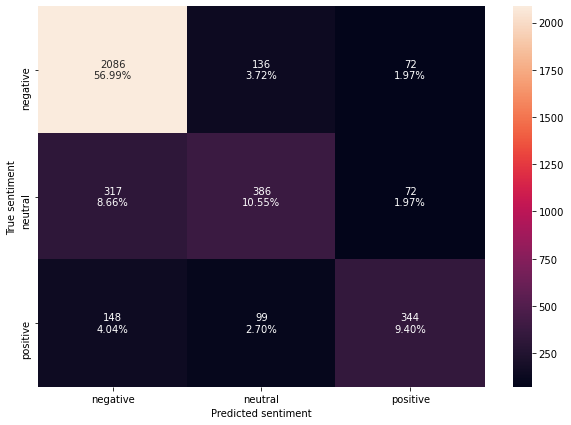

In [31]:
# creating confusion matrix
make_confusion_matrix(y_test1, count_vectorizer_predicted)

- A significant portion of correctly predicted results are negative sentiment,  because most records from our dataset are of negative sentement.
- Among those wrongly predicted results, the model wrongly predicted the most on true neutral sentiment as negative sentiment, which recorded 8.66% of the predictions.

#### Word Cloud of top 40 important features from the CountVectorizer + Random Forest based model:

thank,not,great,usairways,delay,jetblue,flight,http,love,unite,americanair,hours,southwestair,awesome,wait,get,hold,cancel,bag,amaze,customer,time,follow,virginamerica,hour,best,service,dm,help,please,try,fly,tell,call,make,flightled,need,go,much,say,
 


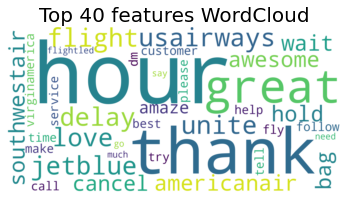

In [32]:
all_features = Count_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf1.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ")   

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### 5.2) Using Term Frequency(TF) - Inverse Document Frequency(IDF)

In [33]:
# Split data into training and testing set.
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_features2, labels, test_size=0.25, 
                                                        stratify=labels, random_state=42)

In [34]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf2 = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf2, X_train2, y_train2, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

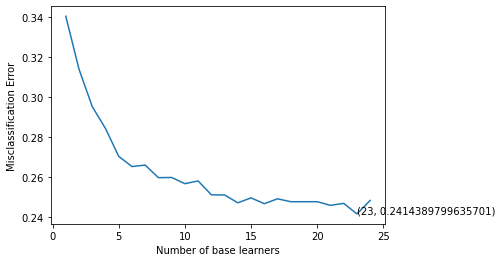

In [35]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [36]:
# Training the best model and calculating accuracy on test data .
clf2 = RandomForestClassifier(n_estimators = optimal_learners)
clf2.fit(X_train2, y_train2)
clf2.score(X_test2, y_test2)

tf_idf_predicted = clf2.predict(X_test2)  # #saving the prediction on test data 
print(classification_report(y_test2 ,tf_idf_predicted , 
                            target_names = ['negative' , 'neutral', 'positive']))
print("Accuracy of the model is : ",accuracy_score(y_test2,tf_idf_predicted))
print("micro avg f1_score of the model is : ", f1_score(y_test2, tf_idf_predicted,average='micro'))

              precision    recall  f1-score   support

    negative       0.78      0.95      0.86      2294
     neutral       0.65      0.41      0.50       775
    positive       0.76      0.49      0.59       591

    accuracy                           0.76      3660
   macro avg       0.73      0.62      0.65      3660
weighted avg       0.75      0.76      0.74      3660

Accuracy of the model is :  0.760655737704918
micro avg f1_score of the model is :  0.760655737704918


- Using TF-IDF has derived similar results to using CountVectorizer, even though the accuracy score with TF-IDF is slightly lower.

[[2179   79   36]
 [ 403  316   56]
 [ 213   89  289]]


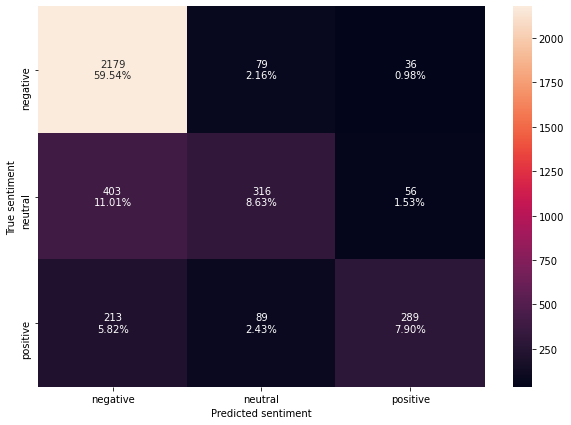

In [37]:
# creating confusion matrix
make_confusion_matrix(y_test2, tf_idf_predicted)

- The  outcome is similar to the previous model.
- There are more correctly predicted negative sentiment than the previous models, but lesser correct predictions of neutal and postive sentiments.
- Again among those wrongly predicted results, the model wrongly predicted the most on true neutral sentiment as negative sentiment, which recorded 11% of the predictions.

#### Word Cloud of top 40 important features from the TF-IDF + Random Forest based model:

thank,not,jetblue,southwestair,americanair,unite,usairways,http,great,flight,love,delay,virginamerica,get,hours,wait,hold,awesome,cancel,dm,call,bag,please,follow,service,amaze,good,fly,appreciate,hour,much,best,time,still,help,go,would,try,do,plane,
 


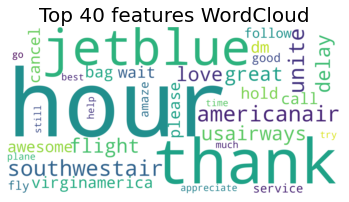

In [38]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf2.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ")   

wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

- Most of top 40 important features from the model using TF-IDF are the same as from the previous model using CountVectorizer.

## 6) Conclusion

- A dataset which has reviews in text format and their sentiment of 'negative' , 'neutral' or 'positive' was used.
- The goal was to build a model for text-classification using Count Vectorizer and TF-IDF.
- Some Word Cloud plots were createed based on airline sentiments and negative reasons.
- The data was pre-processed using various techniques and libraries.
- The pre-processed data is converted to numbers (vectorized), so that it can be fed into the models.
- The models were trained and the parameters were optimized, which led to an increase the overall accuracy.
- After building the classification model, the results were predicted for the test data.
- By using the above techniques, both models performed well in perspective of how text classification models perform.
- However, the accuracy of the models can still be increased by increasing the max_feature parameter in the vectorizer.
- Other model tuning and hyperparameter tuning techniques can be applied, as well as other pre-processing techniques to increase the overall accuracy even further.
- For each of the model, a Word Cloud plot was created based on top 40 important features for different models. Most important features include thank, great, delay, love, wait, cancel, awesome, service, best, amaze, appreciate, etc.